In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
IPython.CodeCell.options_default.cm_config.autoCloseBrackets = false;

<IPython.core.display.Javascript object>

In [4]:
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'load_extensions': {'vim_binding/vim_binding': True},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(
    style='whitegrid',
    font_scale=0.8,
    rc={'lines.linewidth': 1.6, 'lines.markersize': 2},
    font='serif',
)

# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme='oceans16')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
#jtplot.style(context='notebook', fscale=1, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size

from mpl_toolkits import mplot3d

In [7]:
import numpy as np
import pathos.pools as pp
from sklearn.gaussian_process.kernels import Matern
import supercubos
import maszcal.cosmology
import maszcal.corrections
import maszcal.data.sims
import maszcal.data.obs
import maszcal.density
import maszcal.fitutils
import maszcal.lensing
import maszcal.likelihoods
import maszcal.twohalo

In [9]:
PARAM_MINS = np.array([-2, 0, 1, 0.1, 0.1])  # a_sz, con, alpha, beta
PARAM_MAXES = np.array([2, 5, 6, 2.1, 8.1])
GAMMA = 0.2

MIN_MU = np.log(3e13)
MAX_MU = np.log(3e14)

Z_MIN = 0.2
Z_MAX = 1

RADII = np.geomspace(1e-1, 20, 100)

SEED = 13

NUM_CLUSTERS = 200
NUM_PROCESSES = 12

In [10]:
def get_density_model():
    return maszcal.density.MatchingGnfw(
        cosmo_params=maszcal.cosmology.CosmoParams(),
        mass_definition='mean',
        delta=200,
        comoving_radii=True,
        nfw_class=maszcal.density.MatchingNfwModel,
    )


def get_two_halo_esd():
    model = maszcal.twohalo.TwoHaloShearModel(
        cosmo_params=maszcal.cosmology.CosmoParams(),
        mass_definition='mean',
        delta=200,
    )
    return model.excess_surface_density


def get_2h_emulator(two_halo_esd):
    return maszcal.twohalo.TwoHaloEmulator.from_function(
        two_halo_func=two_halo_esd,
        r_grid=np.geomspace(0.01, 100, 120),
        z_lims=np.array([0, Z_MAX+0.01]),
        mu_lims=np.log(np.array([1e13, 3e15])),
        num_emulator_samples=800,
    )


def get_corrected_lensing_func(density_model, two_halo_emulator):
    return maszcal.corrections.Matching2HaloCorrection(
        one_halo_func=density_model.excess_surface_density,
        two_halo_func=two_halo_emulator,
    ).corrected_profile


def get_shear_model(lensing_func):
    rng = np.random.default_rng(seed=SEED)
    sz_mus = (MAX_MU - MIN_MU) * rng.random(size=NUM_CLUSTERS) + MIN_MU
    sz_masses = np.exp(sz_mus)
    zs = Z_MAX*rng.random(size=NUM_CLUSTERS) + Z_MIN
    weights = np.ones(NUM_CLUSTERS)
    return maszcal.lensing.MatchingShearModel(
        sz_masses=sz_masses,
        redshifts=zs,
        lensing_weights=weights,
        lensing_func=lensing_func,
    )


def _pool_map(func, array):
    pool = pp.ProcessPool(NUM_PROCESSES)
    mapped_array = np.array(
        pool.map(func, array),
    ).T
    pool.close()
    pool.join()
    pool.clear()
    pool.terminate()
    pool.restart()
    return mapped_array

In [11]:
nsamps = 1200
rng = np.random.default_rng(seed=SEED)
lh = supercubos.LatinSampler(rng=rng).get_lh_sample(PARAM_MINS, PARAM_MAXES, nsamps)
lh_raw = (lh - PARAM_MINS)/(PARAM_MAXES - PARAM_MINS)
lh_names = [
    r'$a_\mathrm{SZ}$',
    r'$a_\mathrm{2h}$',
    r'$c$',
    r'$\alpha$',
    r'$\beta$'
]

In [12]:
density_model = get_density_model()
two_halo_esd = get_two_halo_esd()
two_halo_emulator = get_2h_emulator(two_halo_esd)
corrected_lensing_func = get_corrected_lensing_func(density_model, two_halo_emulator)
shear_model = get_shear_model(corrected_lensing_func)

def wrapped_esd_func(params):
    a_sz = params[0:1]
    a_2h = params[1:2]
    con = params[2:3]
    alpha = params[3:4]
    beta = params[4:5]
    gamma = np.array([GAMMA])
    return shear_model.stacked_excess_surface_density(RADII, a_sz, a_2h, con, alpha, beta, gamma).squeeze()

esds = _pool_map(wrapped_esd_func, lh)

data = RADII[:, None] * esds
emulator = maszcal.emulate.PcaEmulator.create_from_data(
    coords=lh,
    data=data,
    interpolator_class=maszcal.interpolate.GaussianProcessInterpolator,
    interpolator_kwargs={'kernel': Matern()},
    num_components=12,
)

/Users/sophia/.local/venv/maszcal/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/sophia/.local/venv/maszcal/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [13]:
rs = RADII

In [14]:
colors = ['#c37834', '#4b9cc6', '#7a9e38', '#c2605c', '#629966']

In [15]:
rand = supercubos.LatinSampler(rng=rng).get_rand_sample(PARAM_MINS, PARAM_MAXES, nsamps)
rand_raw = (rand - PARAM_MINS)/(PARAM_MAXES - PARAM_MINS)
rand_names = lh_names

sym = supercubos.LatinSampler(rng=rng).get_sym_sample(PARAM_MINS, PARAM_MAXES, nsamps)
sym_raw = (sym - PARAM_MINS)/(PARAM_MAXES - PARAM_MINS)
sym_names = lh_names

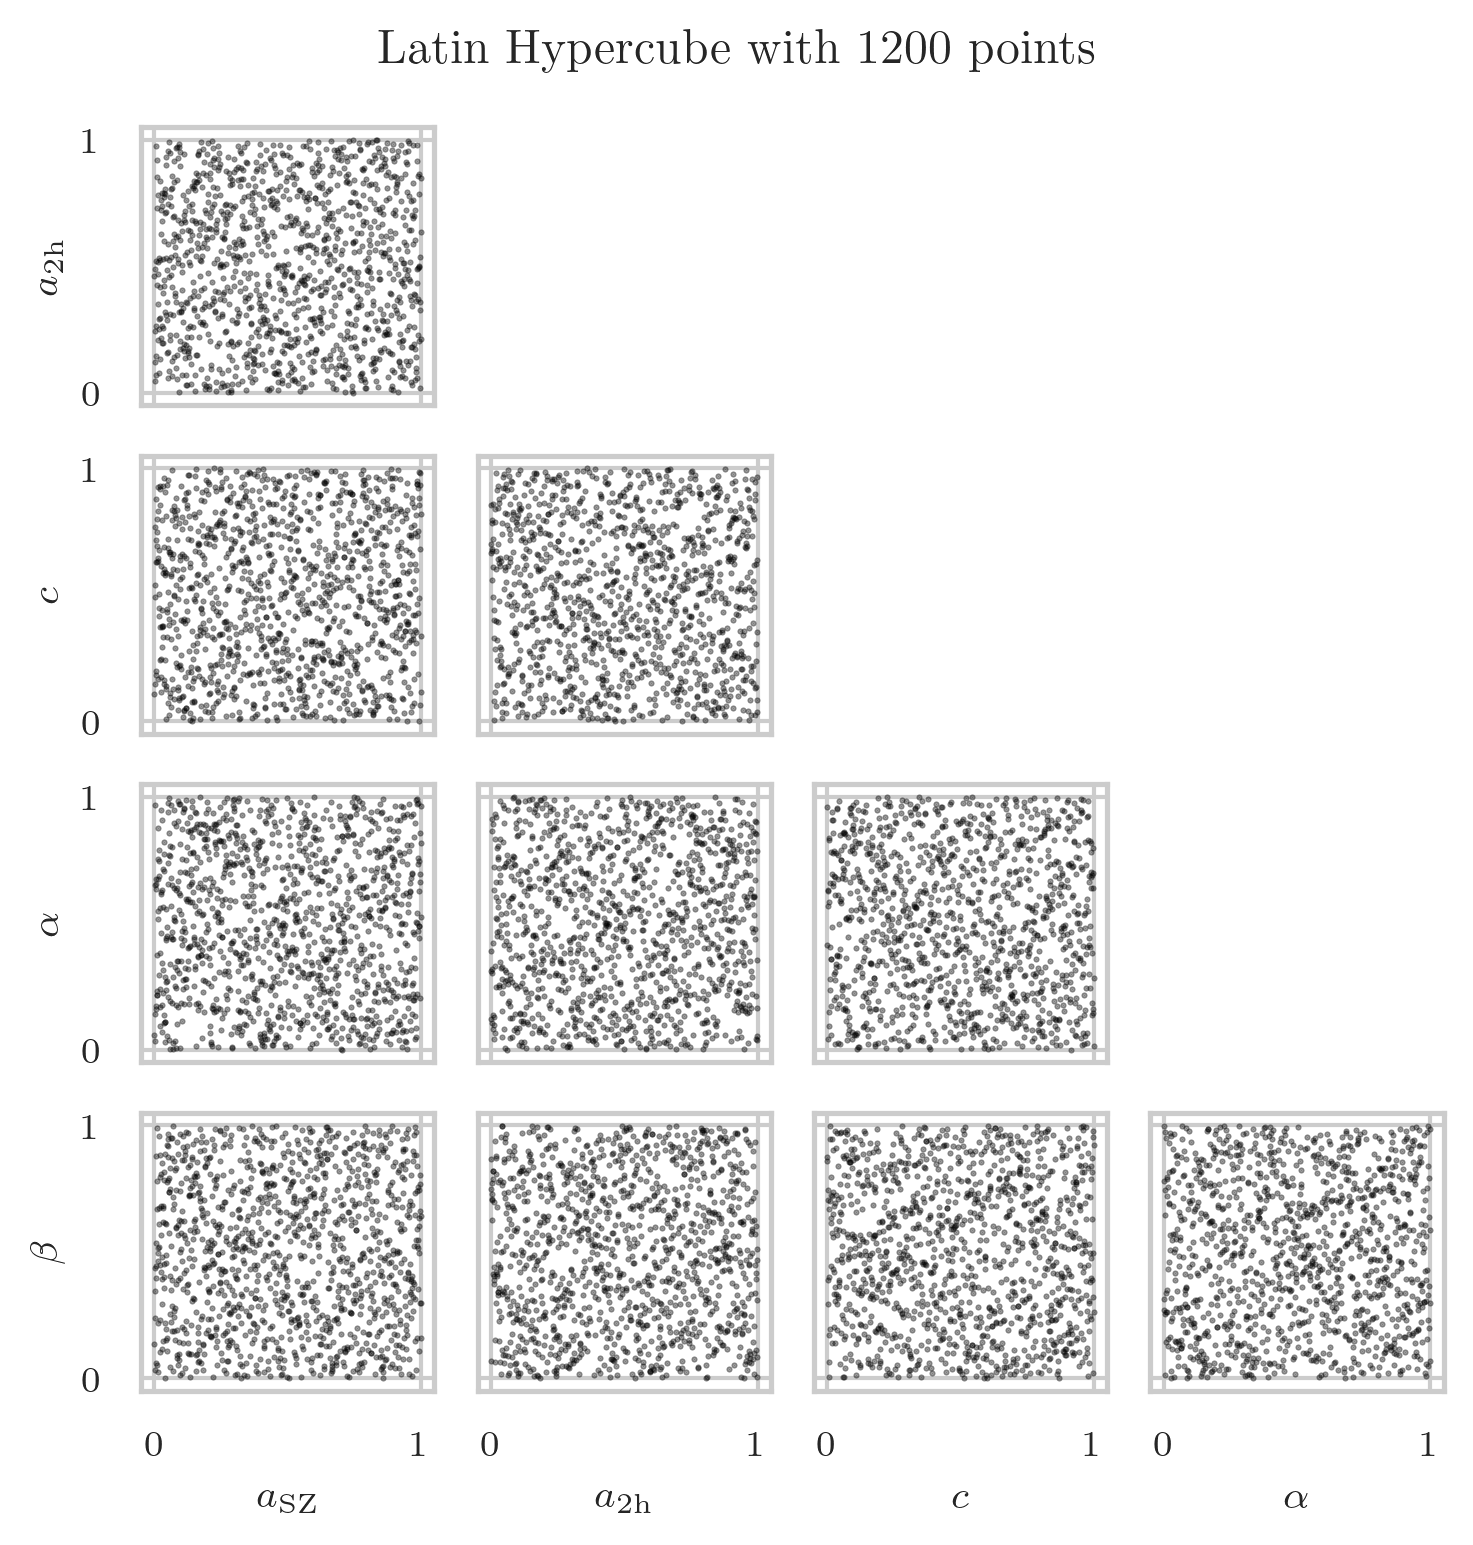

In [16]:
NUM_BINS = 20


temp = np.zeros((5, 5, NUM_BINS, NUM_BINS))
for i in range(5):
    for j in range(5):
        if j < i:
            b, xe, ye = np.histogram2d(lh_raw[:, j], lh_raw[:, i], bins=NUM_BINS)
            temp[i, j, :, :] = b
vmax = temp.max()


cmap = sns.color_palette('crest_r', as_cmap=True)
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        if j < i:
            ax[i-1, j].scatter(lh_raw[:, j], lh_raw[:, i], s=0.2, color='black', alpha=0.5)
            ax[i-1, j].set_xticks((0, 1))
            ax[i-1, j].set_yticks((0, 1))
            #ax[i-1, j].hist2d(lh_raw[:, j], lh_raw[:, i], bins=NUM_BINS, alpha=0.9,
            #                  cmap=cmap, vmin=0, vmax=vmax)
            if i == 4:
                ax[i-1, j].set_xlabel(lh_names[j])
            if j == 0:
                ax[i-1, j].set_ylabel(lh_names[i])
        elif j > i:
            try:
                ax[i, j].remove()
            except IndexError:
                pass
fig.suptitle(f'Latin Hypercube with {nsamps} points')
plt.gcf().set_size_inches(5, 5.2)
plt.savefig('../figs/emulator-analysis/lh-cornerplot.pdf', bbox_inches='tight')
pass

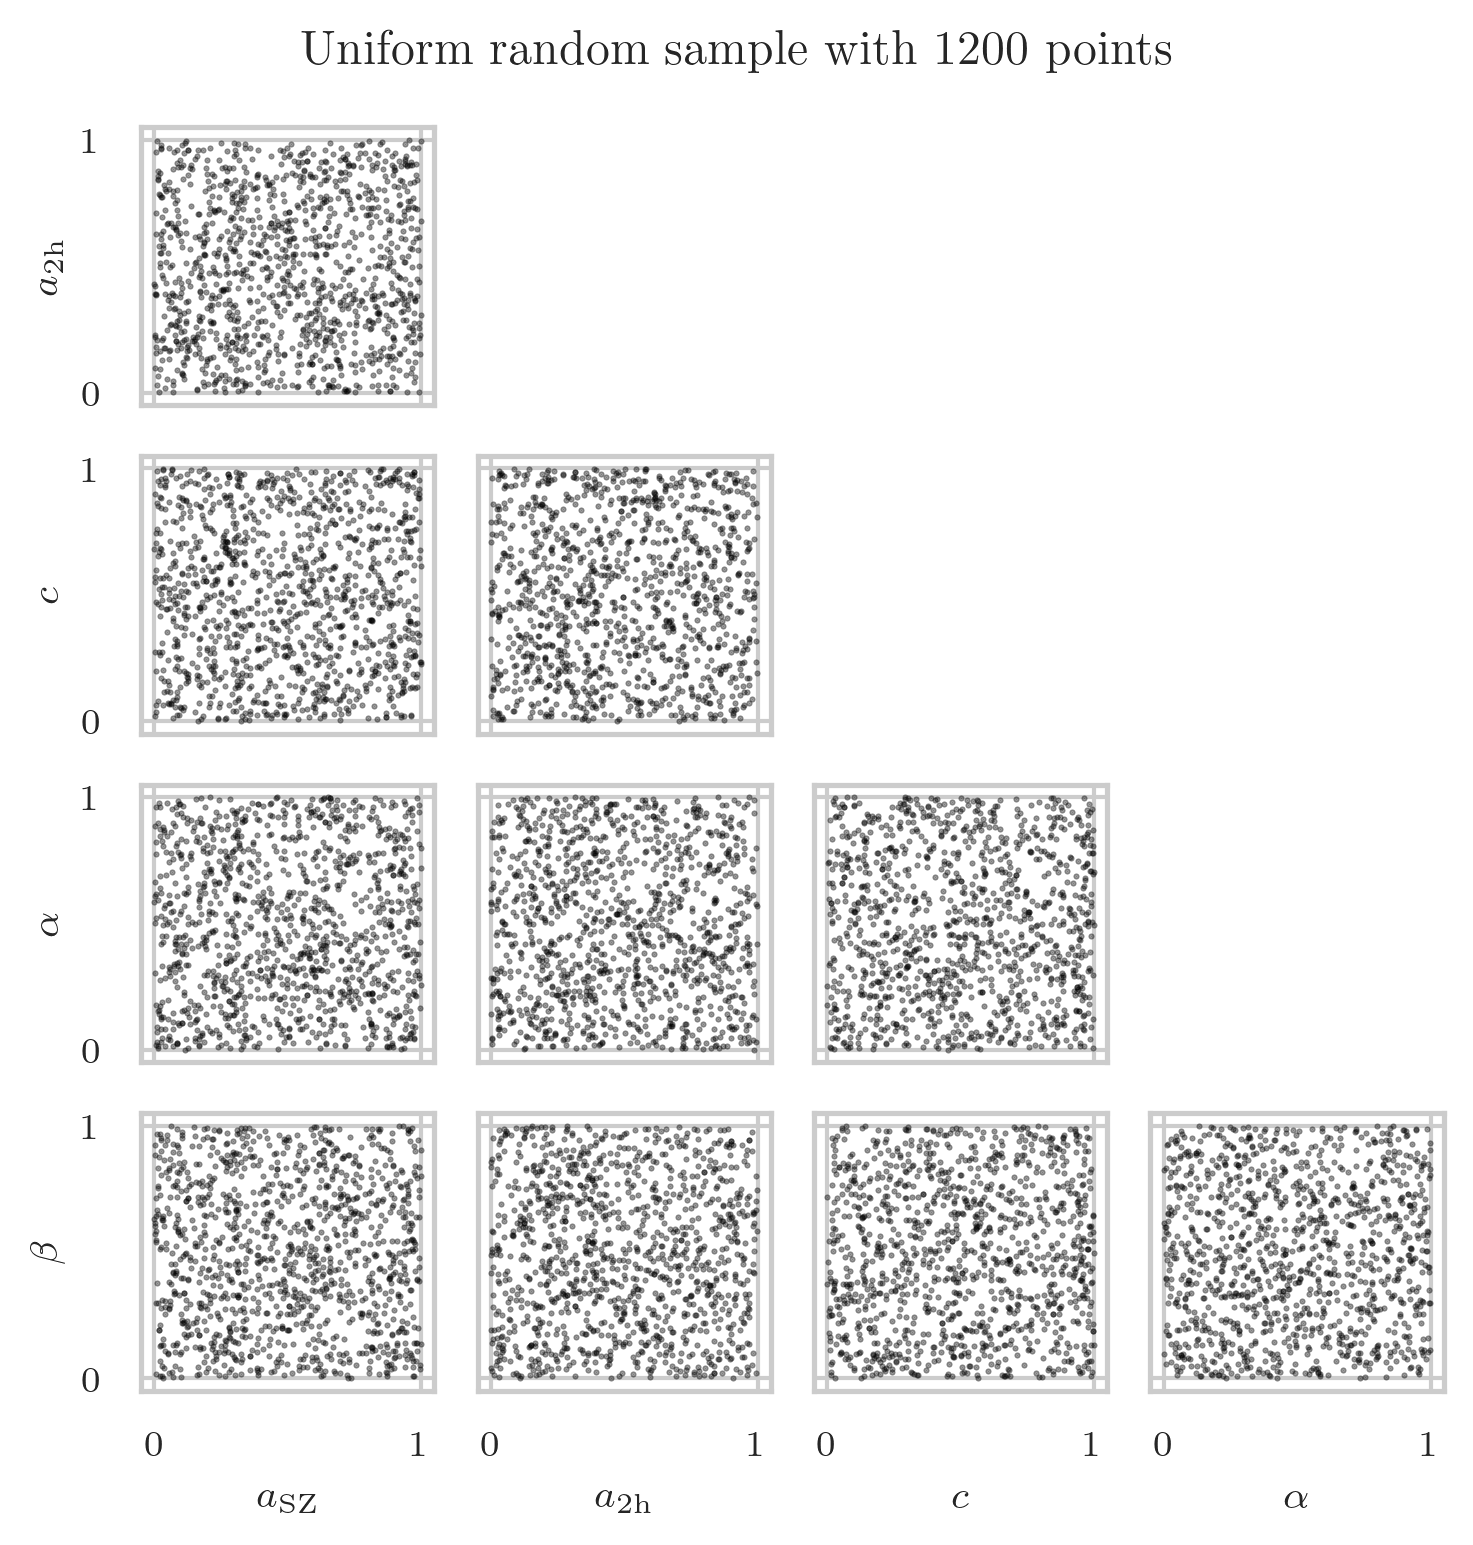

In [17]:
NUM_BINS = 30


temp = np.zeros((5, 5, NUM_BINS, NUM_BINS))
for i in range(5):
    for j in range(5):
        if j < i:
            b, xe, ye = np.histogram2d(rand_raw[:, j], rand_raw[:, i], bins=NUM_BINS)
            temp[i, j, :, :] = b
vmax = temp.max()


cmap = sns.color_palette('crest_r', as_cmap=True)
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
for i in range(5):
    for j in range(5):
        if j < i:
            ax[i-1, j].scatter(rand_raw[:, j], rand_raw[:, i], s=0.2, color='black', alpha=0.5)
            ax[i-1, j].set_xticks((0, 1))
            ax[i-1, j].set_yticks((0, 1))
            #ax[i-1, j].hist2d(rand_raw[:, j], rand_raw[:, i], bins=NUM_BINS, alpha=1,
            #                  cmap=cmap, vmin=0, vmax=vmax)
            if i == 4:
                ax[i-1, j].set_xlabel(rand_names[j])
            if j == 0:
                ax[i-1, j].set_ylabel(rand_names[i])
        elif j > i:
            try:
                ax[i, j].remove()
            except IndexError:
                pass
fig.suptitle(f'Uniform random sample with {nsamps} points')
plt.gcf().set_size_inches(5, 5.2)
plt.savefig('../figs/emulator-analysis/rand-cornerplot.pdf', bbox_inches='tight')
pass

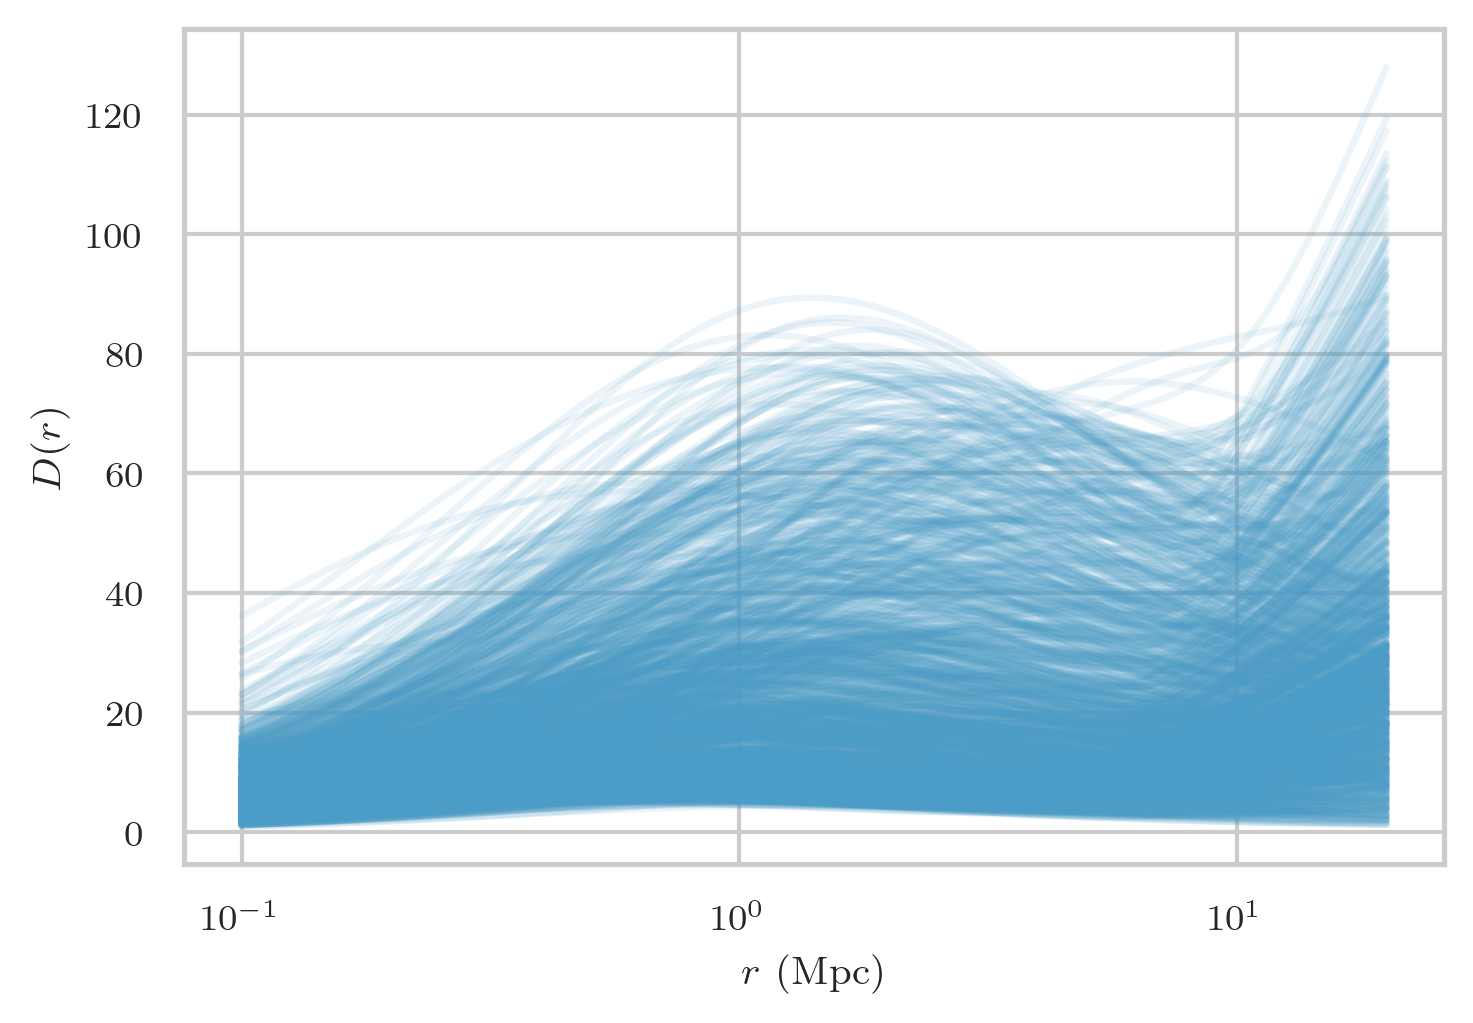

In [18]:
plt.plot(rs, data, color=colors[1], alpha=0.1)
plt.xlabel(r'$r$' + ' (Mpc)')
plt.ylabel(r'$D(r)$')
plt.xscale('log')
plt.gcf().set_size_inches(5, 3.5)

plt.savefig('../figs/emulator-analysis/d-of-r_lh-sample.pdf', bbox_inches='tight')
pass

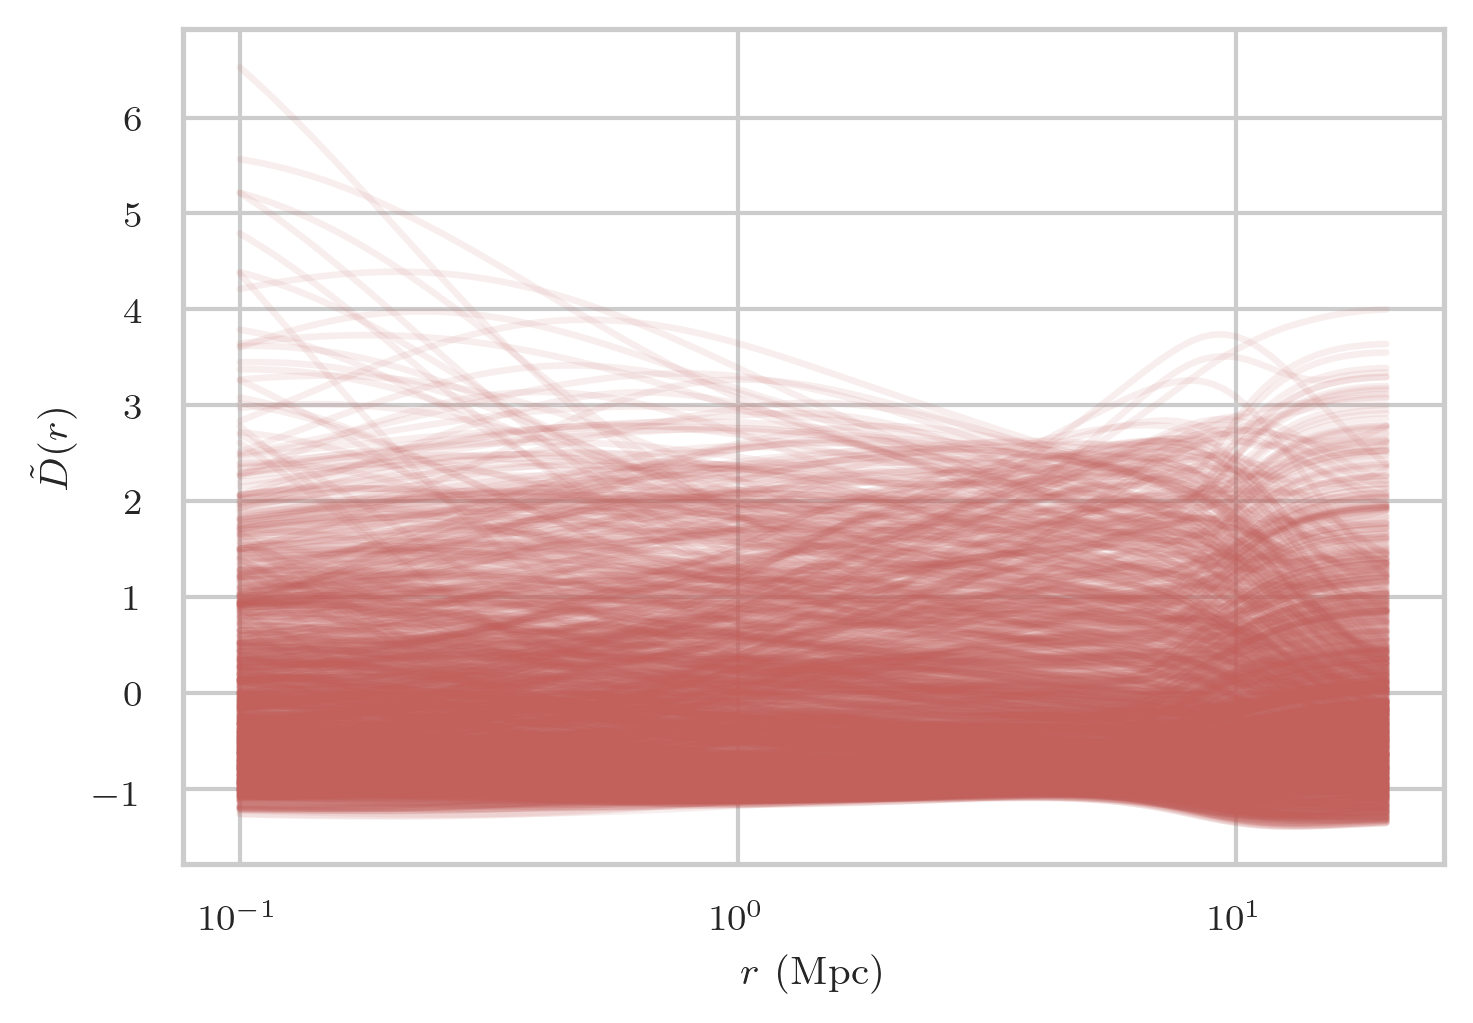

In [19]:
scaled = (data - data.mean(axis=1)[:, None]) / data.std(axis=1)[:, None]
plt.plot(rs, scaled, color=colors[3], alpha=0.1)
plt.xscale('log')
plt.xlabel(r'$r$' + ' (Mpc)')
plt.ylabel(r'$\tilde D(r)$')
plt.gcf().set_size_inches(5, 3.5)
plt.savefig('../figs/emulator-analysis/d-of-r_lh-sample_scaled.pdf', bbox_inches='tight')
pass

In [20]:
basis_vs = emulator.basis_vectors
wgts = emulator.weights
expl_var = emulator.explained_variance

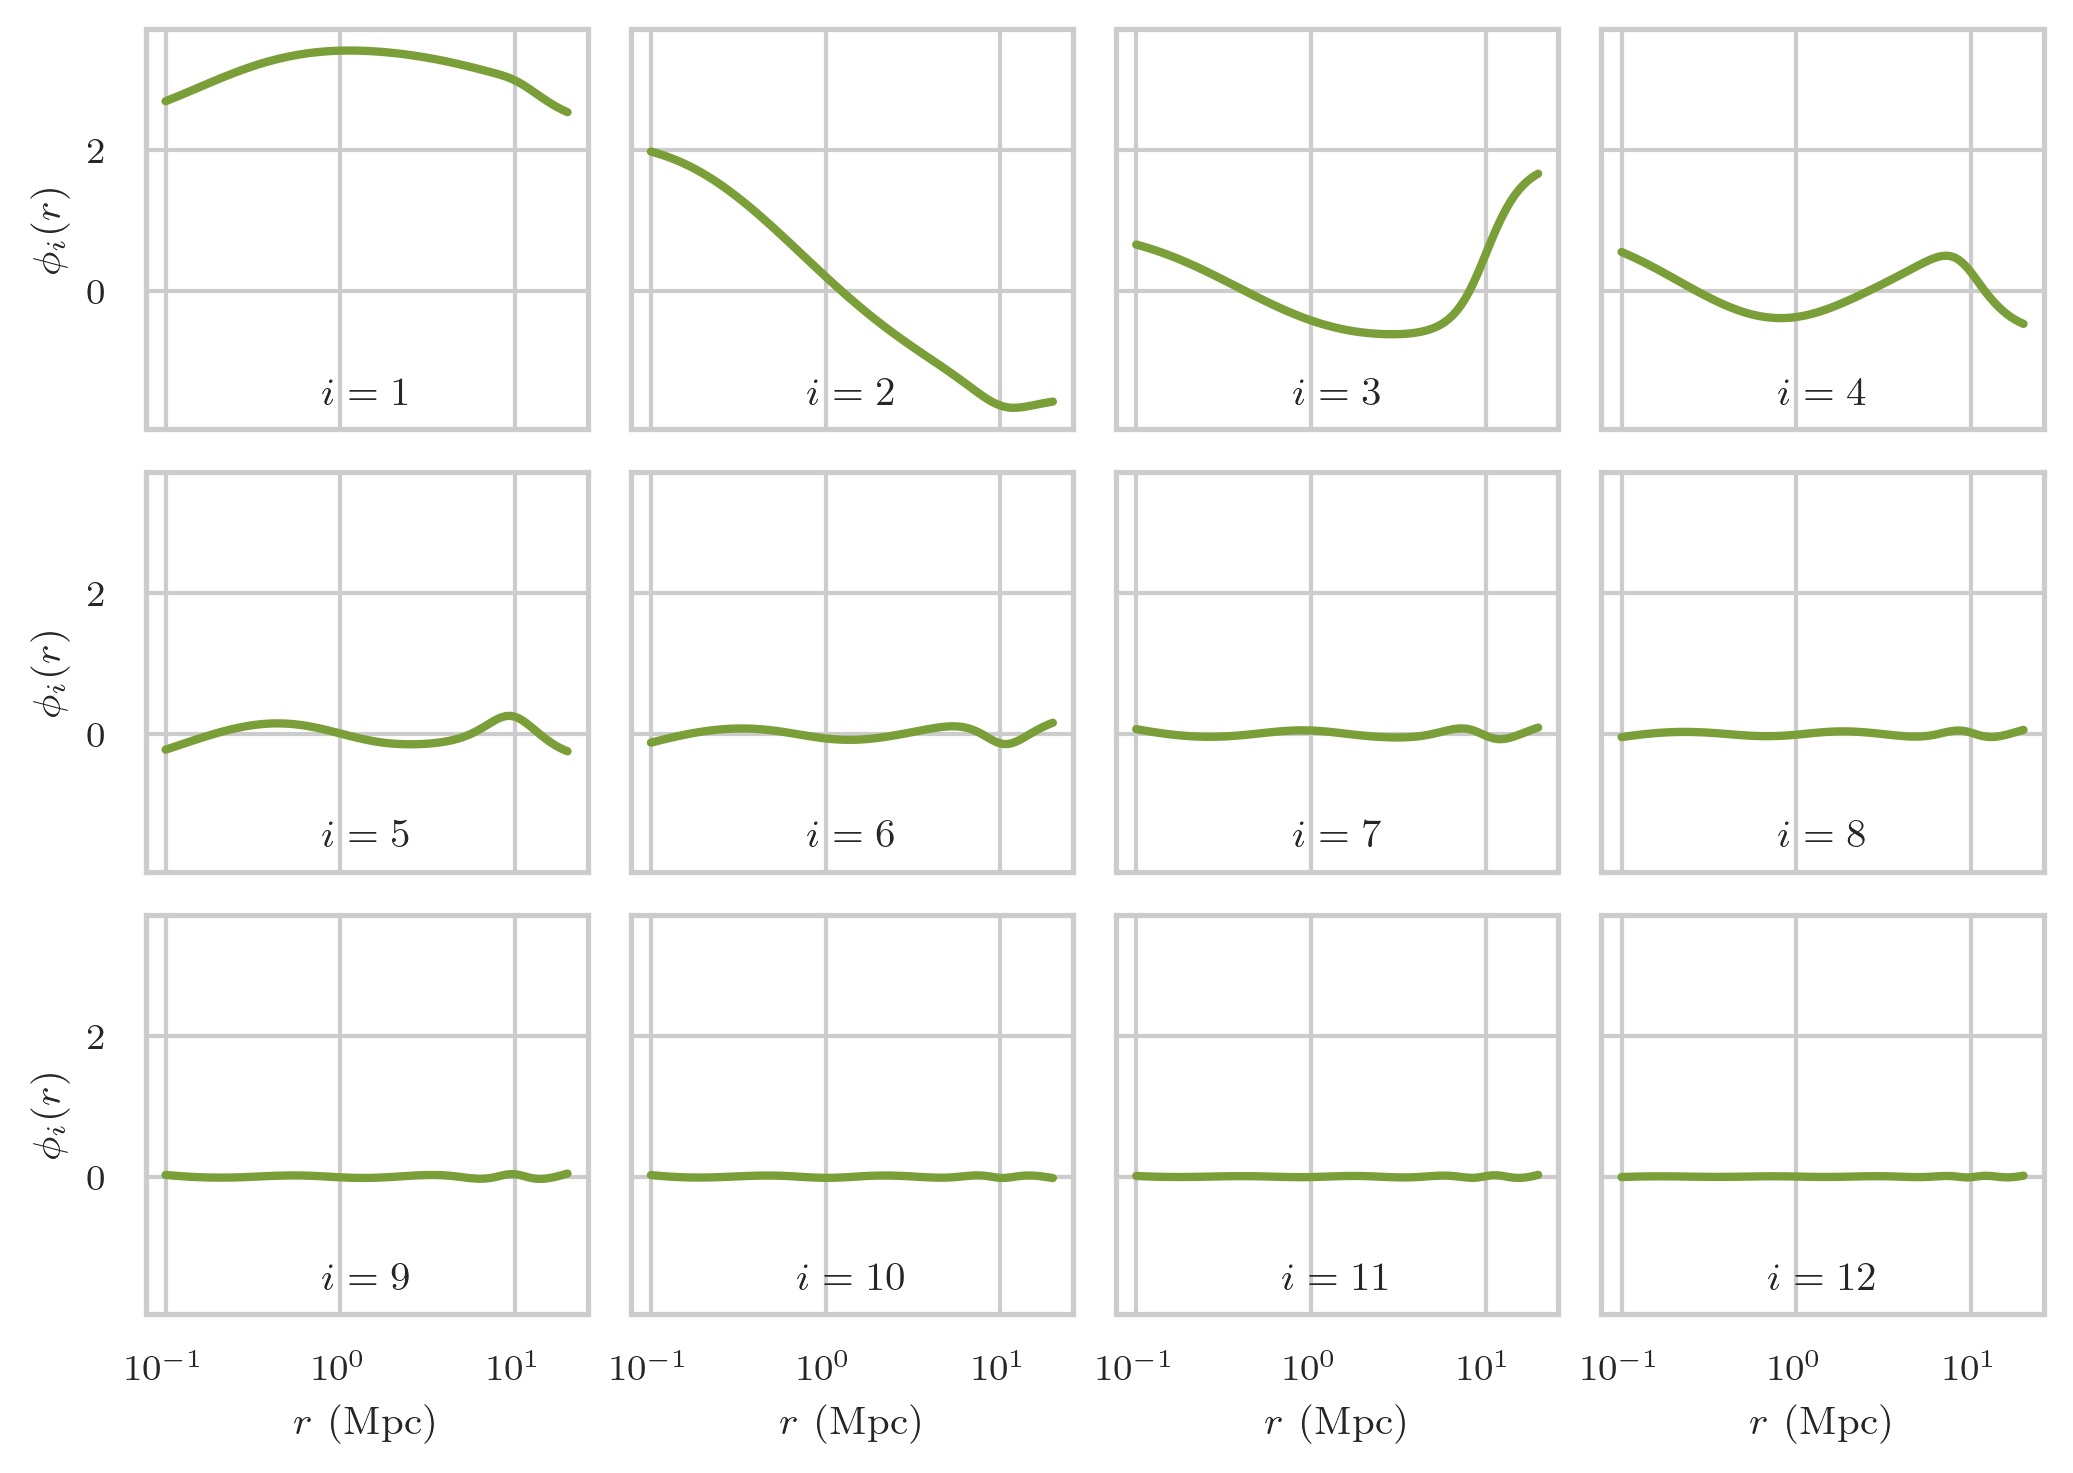

In [21]:
fig, axes = plt.subplots(3, 4, sharex='col', sharey='row')
for i, ax in enumerate(axes.flat):
    ax.plot(rs, basis_vs[:, i], color=colors[2], linewidth=2)
    ax.set_xscale('log')
    ax.set_ylim(basis_vs.min()-0.3, basis_vs.max()+0.3)
    ax.set_title(fr'$i = {i+1}$', loc='center', y=0)
    if i%4 == 0:
        ax.set_ylabel(r'$\phi_i(r)$')
    if 11-i < 4:
        ax.set_xlabel(r'$r$' + ' (Mpc)')
plt.gcf().set_size_inches(7, 5)
plt.savefig('../figs/emulator-analysis/first-12-basis-vectors.pdf', bbox_inches='tight')
pass

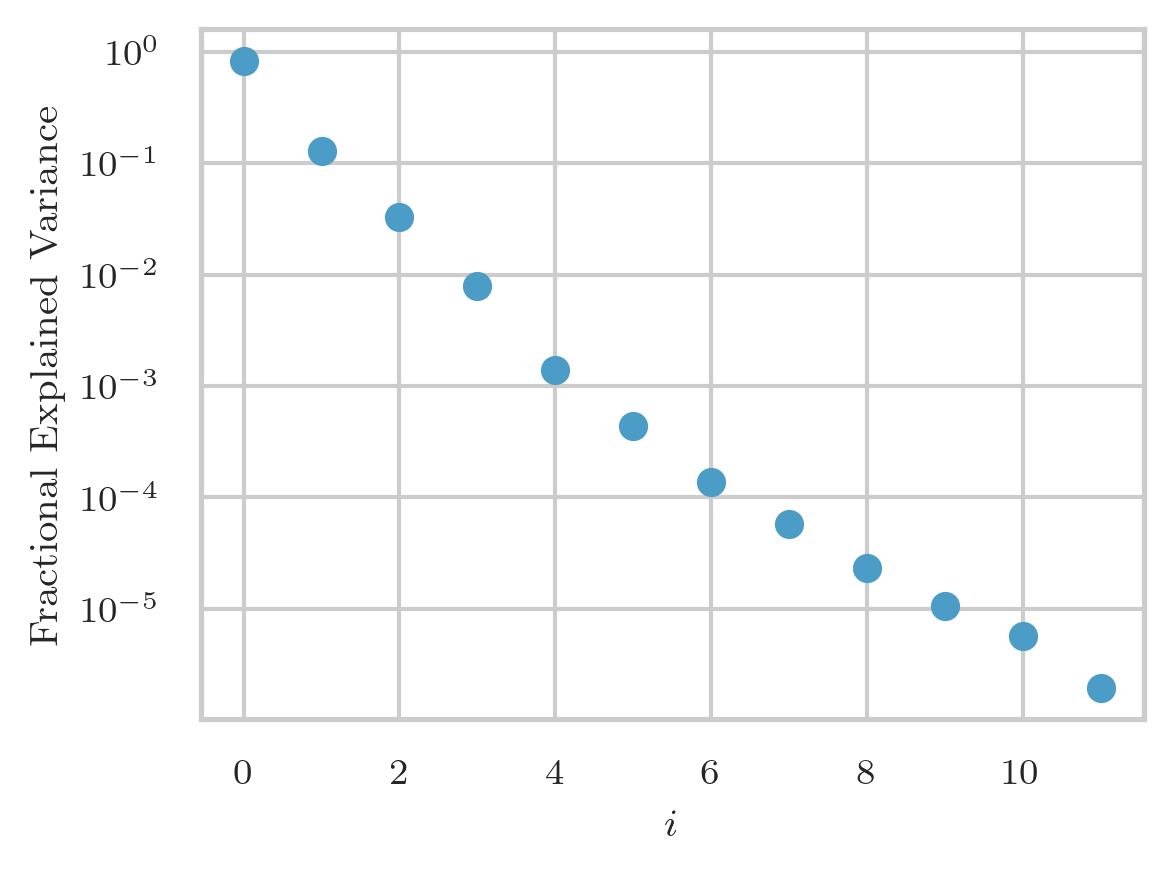

In [22]:
plt.plot(expl_var, marker='o', color=colors[1], markersize=6, linestyle='')
plt.yscale('log')
plt.xlabel(r'$i$')
plt.ylabel('Fractional Explained Variance')
plt.gcf().set_size_inches(4, 3)
plt.savefig('../figs/emulator-analysis/pcs_explained_var.pdf', bbox_inches='tight')
pass

In [23]:
def wrapped_weight_emulator(i, a_szs, a_2hs, cons, alphas, betas):
    params = maszcal.interp_utils.cartesian_prod(
        a_szs,
        a_2hs,
        cons,
        alphas,
        betas,
    )
    return emulator.weight_interpolators[i](params)

In [24]:
(PARAM_MAXES + PARAM_MINS)/2

array([0. , 2.5, 3.5, 1.1, 4.1])

In [25]:
a_szs = 0*np.ones(1)
a_2hs = 2.5*np.ones(1)
cons = 3.5*np.ones(1)
alphas = 1.1*np.ones(1)
betas = 4.1*np.ones(1)
wrapped_weight_emulator(0, a_szs, a_2hs, cons, alphas, betas)

array([-0.10825897])

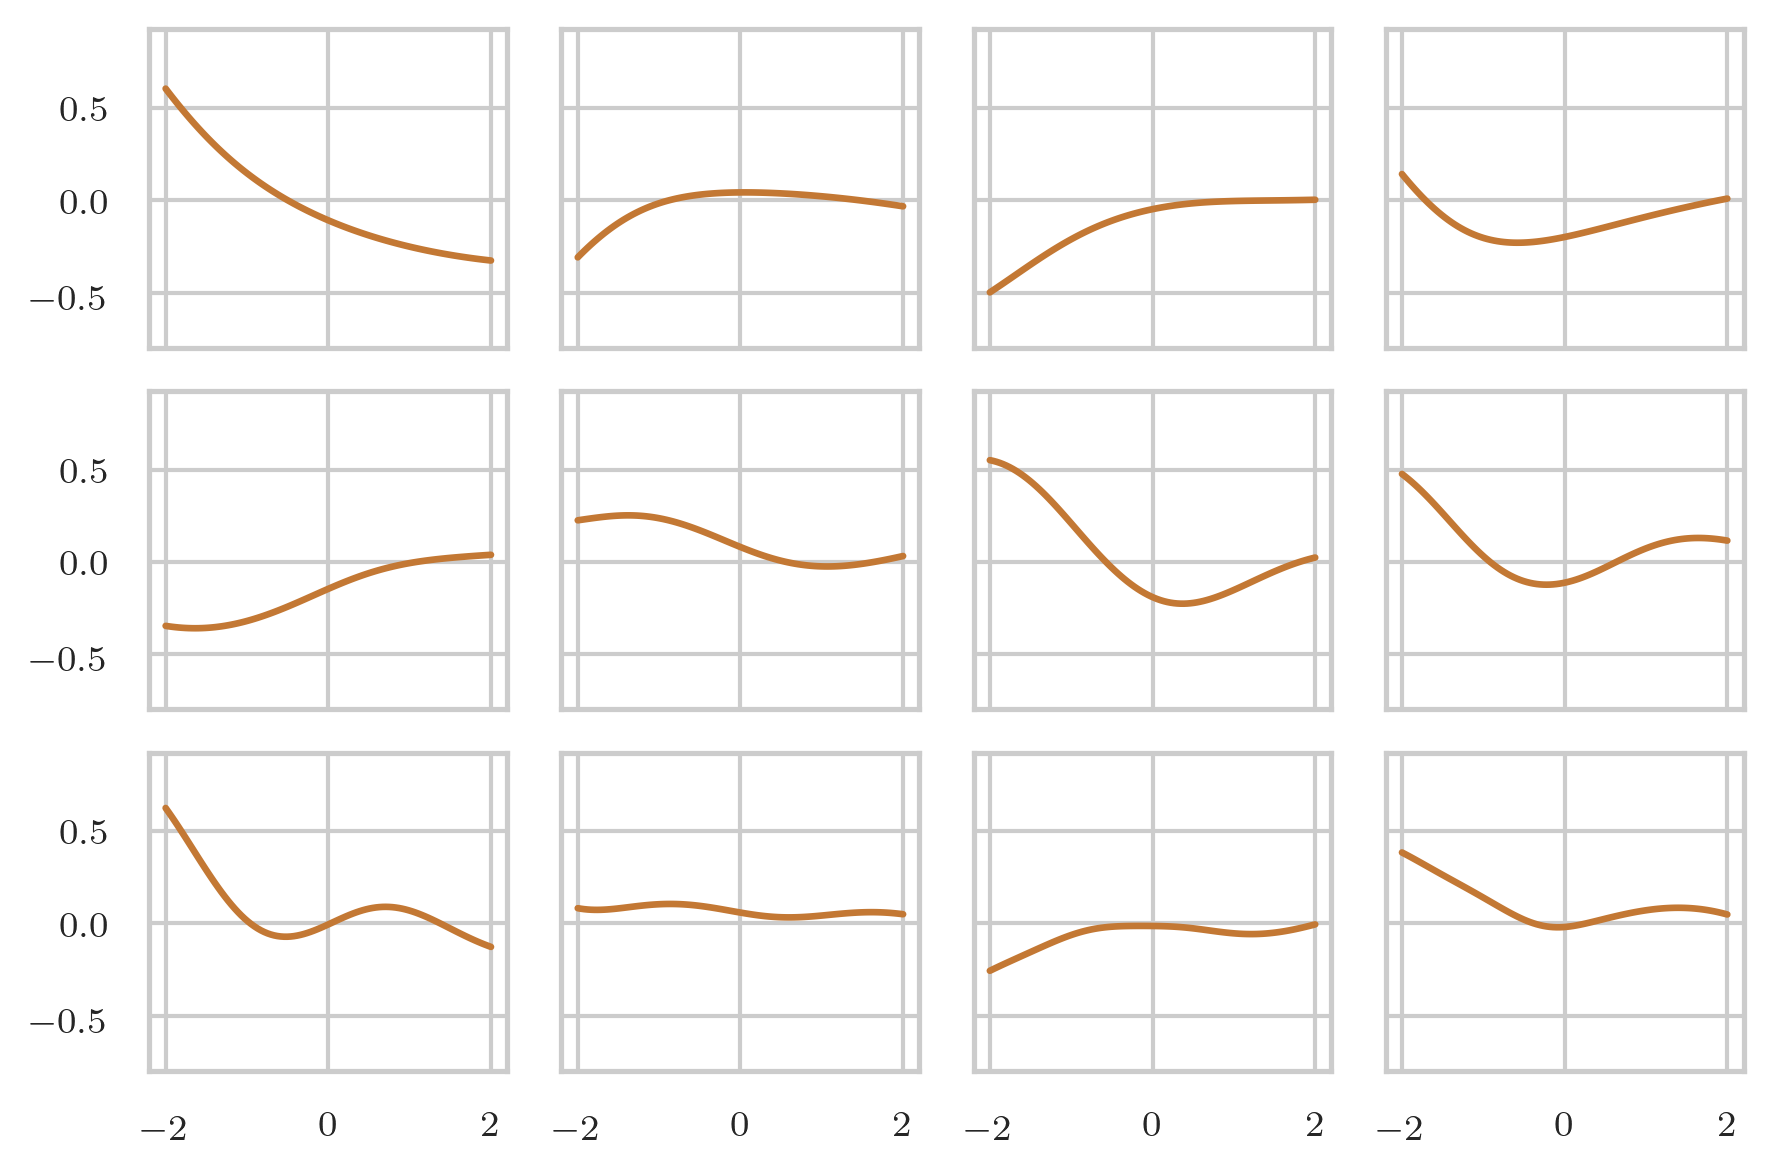

In [26]:
a_szs = np.linspace(PARAM_MINS[0], PARAM_MAXES[0], 100)
a_2hs = 2.5*np.ones(1)
cons = 3.5*np.ones(1)
alphas = 1.1*np.ones(1)
betas = 4.1*np.ones(1)
weights = [wrapped_weight_emulator(i, a_szs, a_2hs, cons, alphas, betas) for i in range(12)]
weights_min = np.array(weights).min()
weights_max = np.array(weights).max()

fig, axes = plt.subplots(3, 4, sharex='col', sharey='row')
for i, ax in enumerate(axes.flat):
    ax.plot(a_szs, weights[i], color=colors[0])
    ax.set_ylim(weights_min-0.3, weights_max+0.3)
pass

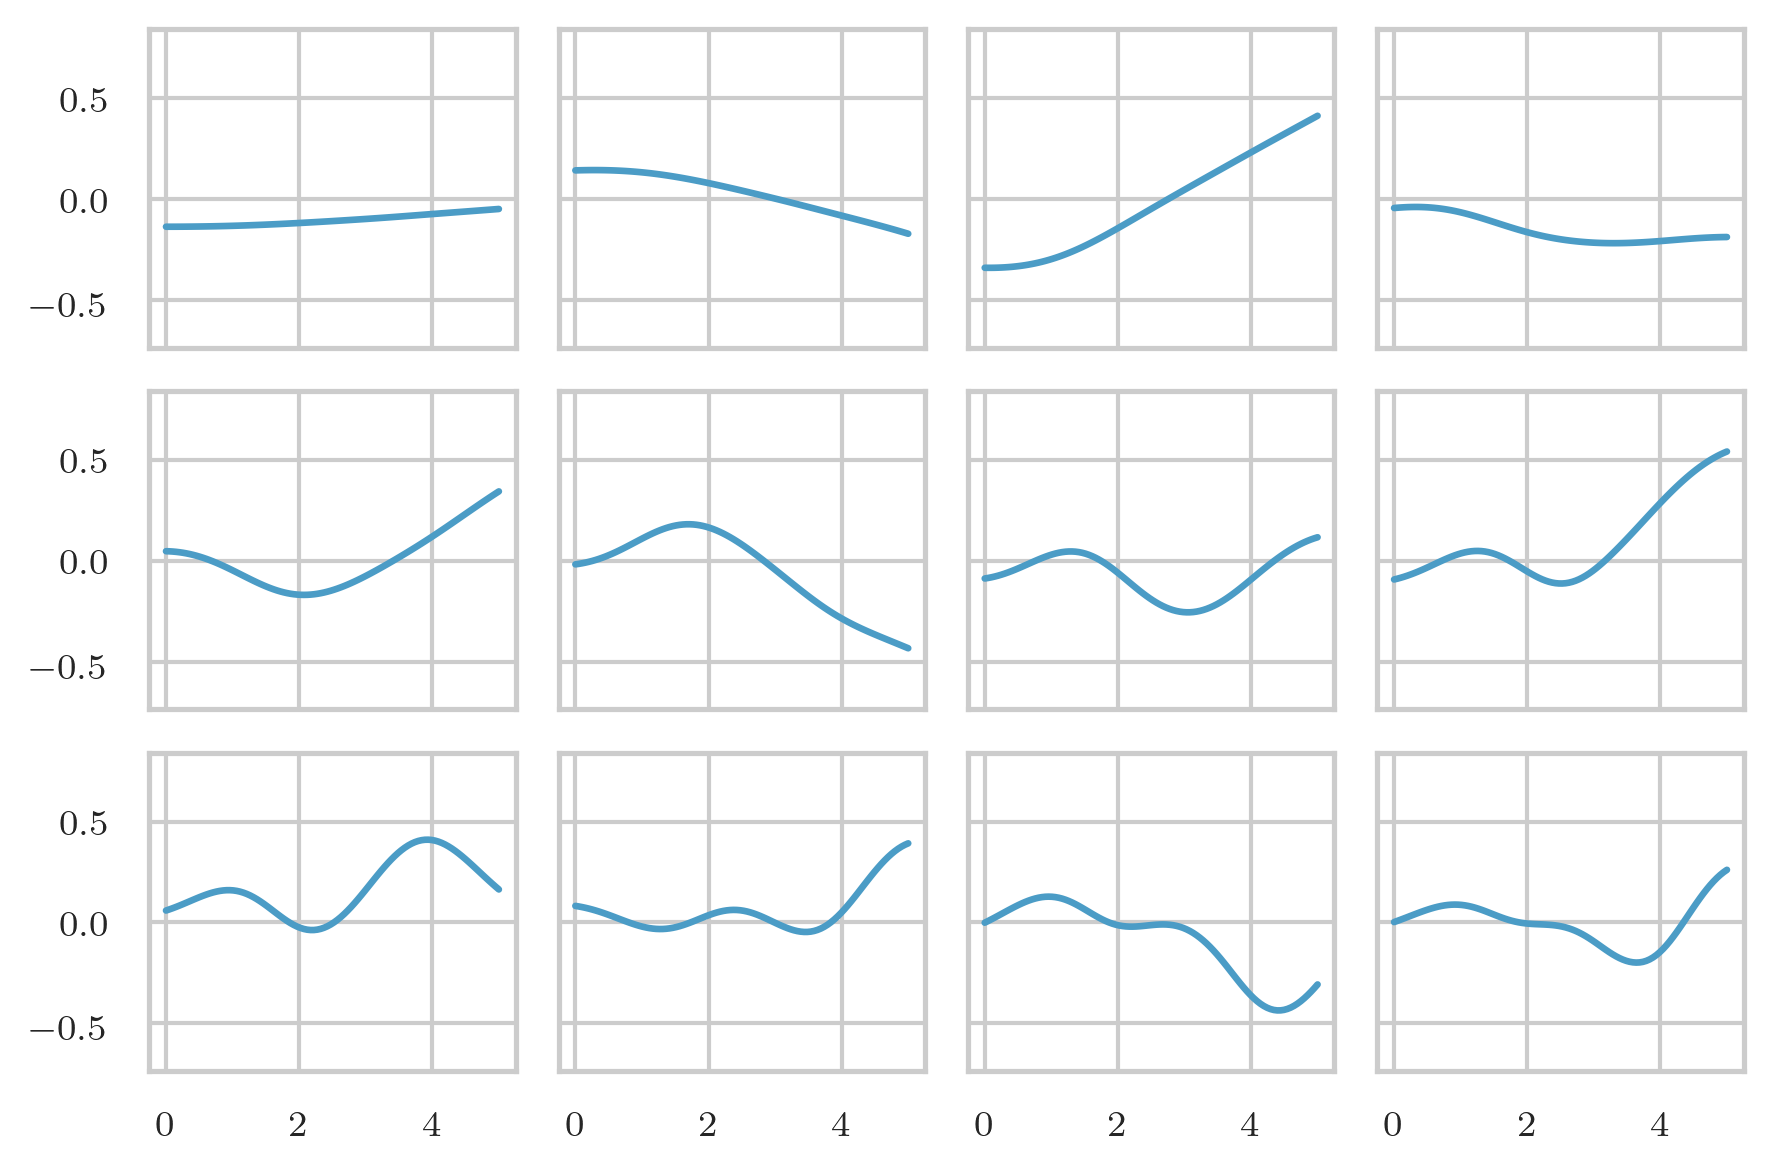

In [27]:
a_szs = 0*np.ones(1)
a_2hs = np.linspace(PARAM_MINS[1], PARAM_MAXES[1], 100)
cons = 3.5*np.ones(1)
alphas = 1.1*np.ones(1)
betas = 4.1*np.ones(1)
weights = [wrapped_weight_emulator(i, a_szs, a_2hs, cons, alphas, betas) for i in range(12)]
weights_min = np.array(weights).min()
weights_max = np.array(weights).max()

fig, axes = plt.subplots(3, 4, sharex='col', sharey='row')
for i, ax in enumerate(axes.flat):
    ax.plot(a_2hs, weights[i], color=colors[1])
    ax.set_ylim(weights_min-0.3, weights_max+0.3)
pass

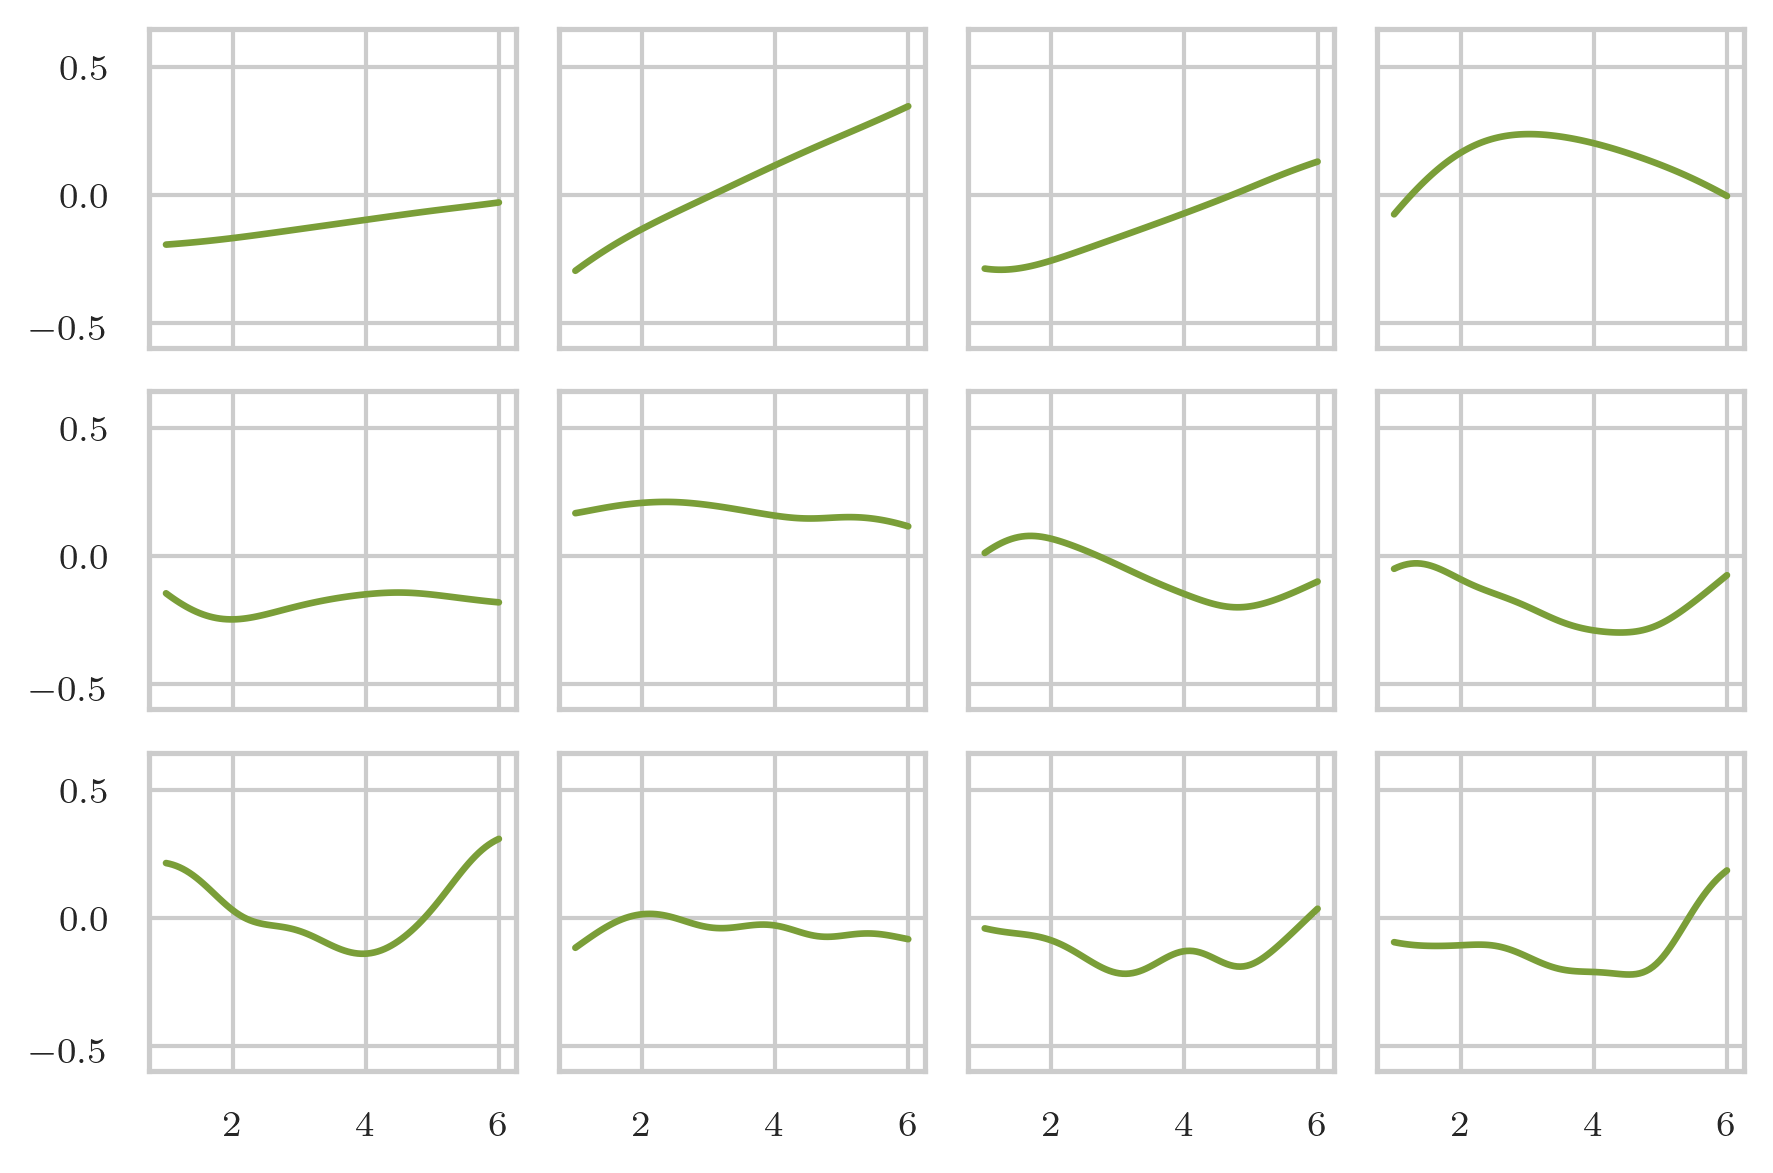

In [32]:
a_szs = 0*np.ones(1)
a_2hs = 2.5*np.ones(1)
cons = np.linspace(PARAM_MINS[2], PARAM_MAXES[2], 100)
alphas = 1.1*np.ones(1)
betas = 4.1*np.ones(1)
weights = [wrapped_weight_emulator(i, a_szs, a_2hs, cons, alphas, betas) for i in range(12)]
weights_min = np.array(weights).min()
weights_max = np.array(weights).max()

fig, axes = plt.subplots(3, 4, sharex='col', sharey='row')
for i, ax in enumerate(axes.flat):
    ax.plot(cons, weights[i], color=colors[2])
    ax.set_ylim(weights_min-0.3, weights_max+0.3)
pass

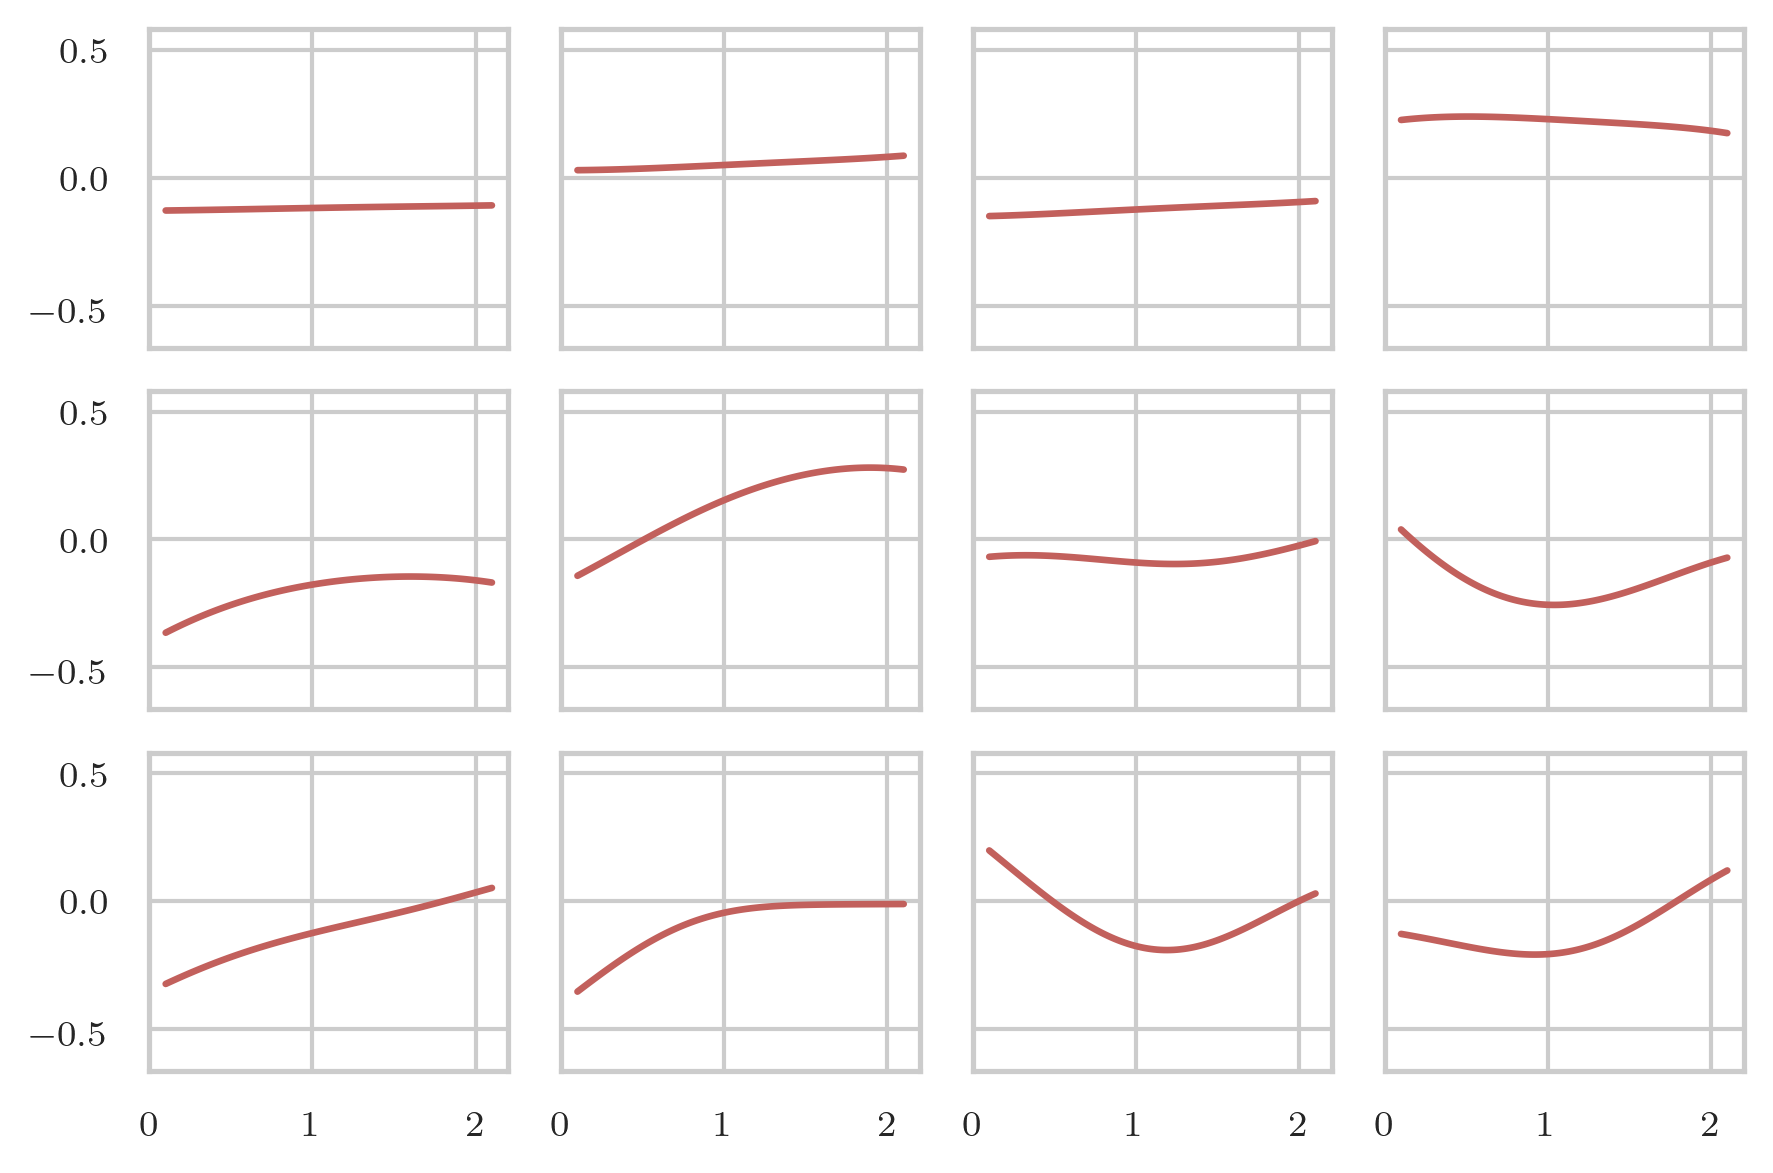

In [33]:
a_szs = 0*np.ones(1)
a_2hs = 2.5*np.ones(1)
cons = 3.5*np.ones(1)
alphas = np.linspace(PARAM_MINS[3], PARAM_MAXES[3], 100)
betas = 4.1*np.ones(1)
weights = [wrapped_weight_emulator(i, a_szs, a_2hs, cons, alphas, betas) for i in range(12)]
weights_min = np.array(weights).min()
weights_max = np.array(weights).max()

fig, axes = plt.subplots(3, 4, sharex='col', sharey='row')
for i, ax in enumerate(axes.flat):
    ax.plot(alphas, weights[i], color=colors[3])
    ax.set_ylim(weights_min-0.3, weights_max+0.3)
pass

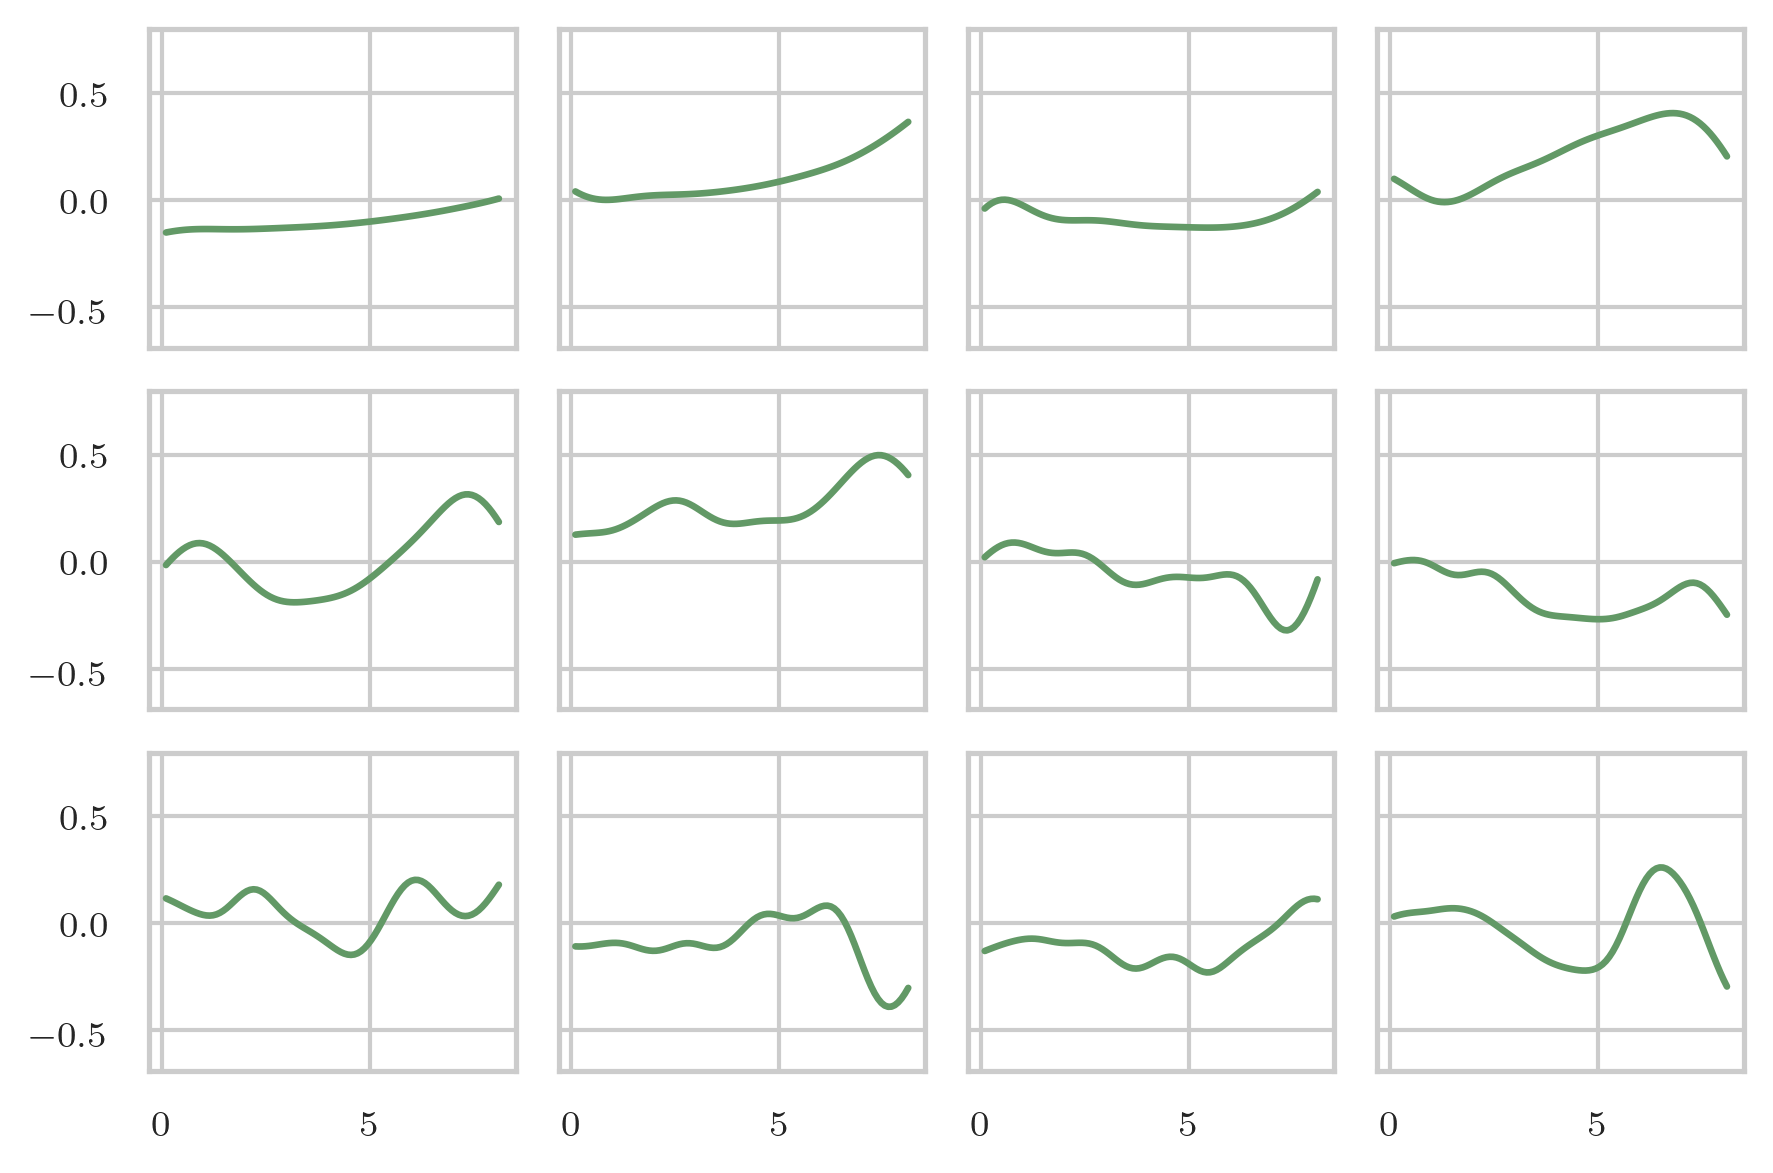

In [34]:
a_szs = 0*np.ones(1)
a_2hs = 2.5*np.ones(1)
cons = 3.5*np.ones(1)
alphas = 1.1*np.ones(1)
betas = np.linspace(PARAM_MINS[4], PARAM_MAXES[4], 100)
weights = [wrapped_weight_emulator(i, a_szs, a_2hs, cons, alphas, betas) for i in range(12)]
weights_min = np.array(weights).min()
weights_max = np.array(weights).max()

fig, axes = plt.subplots(3, 4, sharex='col', sharey='row')
for i, ax in enumerate(axes.flat):
    ax.plot(betas, weights[i], color=colors[4])
    ax.set_ylim(weights_min-0.3, weights_max+0.3)
pass